**Upload File**

In [2]:
from google.colab import files

uploaded = files.upload()

Saving jabodetabek_house_price.csv to jabodetabek_house_price.csv


## **1. Library**

In [1]:
# Library
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

## **2. Load Data**

In [3]:
data = pd.read_csv('jabodetabek_house_price.csv')

## **3. Data Exploration**

In [4]:
print("Data Shape:", data.shape)
print("\nMissing Values:\n", data.isnull().sum())
print("\nData Types:\n", data.dtypes)

Data Shape: (3553, 27)

Missing Values:
 url                        0
price_in_rp                0
title                      0
address                    0
district                   0
city                       0
lat                        0
long                       0
facilities                 0
property_type              1
ads_id                     4
bedrooms                  34
bathrooms                 29
land_size_m2               2
building_size_m2           2
carports                   0
certificate              141
electricity                0
maid_bedrooms              0
maid_bathrooms             0
floors                     6
building_age            1445
year_built              1445
property_condition       246
building_orientation    1647
garages                    0
furnishing               387
dtype: int64

Data Types:
 url                      object
price_in_rp             float64
title                    object
address                  object
district             

## **4. Data Preprocessing**

In [5]:
# Drop unnecessary columns
data = data.drop(['url', 'title', 'address', 'ads_id'], axis=1)



In [6]:
# Handle missing values for numerical columns
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].median())



In [7]:
# Handle missing values for categorical columns
cat_cols = data.select_dtypes(include=['object']).columns
for col in cat_cols:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna('Unknown')

In [8]:
# Extract year from 'year_built' or use 'building_age' if missing
data['property_age'] = 2023 - data['year_built']
data.loc[data['property_age'].isnull(), 'property_age'] = data['building_age']



In [9]:
# Create binary features from facilities
data['has_pool'] = data['facilities'].str.contains('Kolam Renang', case=False).astype(int)
data['has_security'] = data['facilities'].str.contains('Keamanan', case=False).astype(int)
data['has_park'] = data['facilities'].str.contains('Taman', case=False).astype(int)



In [10]:
# Encode categorical variables
label_encoders = {}
for col in cat_cols:
    if col != 'facilities':  # Skip facilities as we've extracted features
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le



In [11]:
# Drop original facilities column
data = data.drop('facilities', axis=1)



## **5. Feature Selection & Split**

In [12]:
X = data.drop('price_in_rp', axis=1)
y = np.log1p(data['price_in_rp'])



In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **6. Model Pipeline & Transformasi**

In [14]:
# Define numerical and categorical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

In [15]:
# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', LabelEncoder())])

In [16]:
# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])




In [17]:
# Create pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', RandomForestRegressor(random_state=42))])



## **7. Hyperparameter Tuning (GridSearchCV)**

In [18]:
# 6. Hyperparameter Tuning
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
    'regressor__max_features': ['sqrt', None]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['district', 'city', 'lat', 'long', 'property_type', 'bedrooms',
       'bathrooms', 'land_size_m2', 'building_size_m2', 'carports',
       'certificate', 'electricity', 'maid_bedr...
                                                                                          LabelEncoder())]),
                                                                         Index([], dtype='object'))])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10],
                         'regressor__max_features': ['sqrt', None],
                         'regressor__min_samples_leaf': [1, 2],
                         'regressor__min_samples_split': [2, 5],
                         'regressor__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [19]:
# Best parameters
print("Best Parameters:", grid_search.best_params_)



Best Parameters: {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}


## **8. Evaluasi Model Terbaik**

In [20]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)



In [21]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"MAE: {mae:,.2f}")
print(f"MSE: {mse:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R2 Score: {r2:.4f}")



Model Performance:
MAE: 0.18
MSE: 0.10
RMSE: 0.32
R2 Score: 0.9193


## **Visualisasi Hasil**

In [22]:
# Get feature names after preprocessing
feature_names = num_features.tolist() + cat_features.tolist()

# For Random Forest feature importance
if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
    importances = best_model.named_steps['regressor'].feature_importances_
    indices = np.argsort(importances)[::-1]

    print("\nFeature Importance:")
    for f in range(X.shape[1]):
        print(f"{feature_names[f]}: {importances[indices[f]]:.4f}")


Feature Importance:
district: 0.2747
city: 0.1841
lat: 0.1092
long: 0.0699
property_type: 0.0610
bedrooms: 0.0491
bathrooms: 0.0489
land_size_m2: 0.0408
building_size_m2: 0.0231
carports: 0.0210
certificate: 0.0191
electricity: 0.0171
maid_bedrooms: 0.0150
maid_bathrooms: 0.0141
floors: 0.0082
building_age: 0.0080
year_built: 0.0071
property_condition: 0.0069
building_orientation: 0.0063
garages: 0.0052
furnishing: 0.0046
property_age: 0.0033
has_pool: 0.0019
has_security: 0.0015
has_park: 0.0000


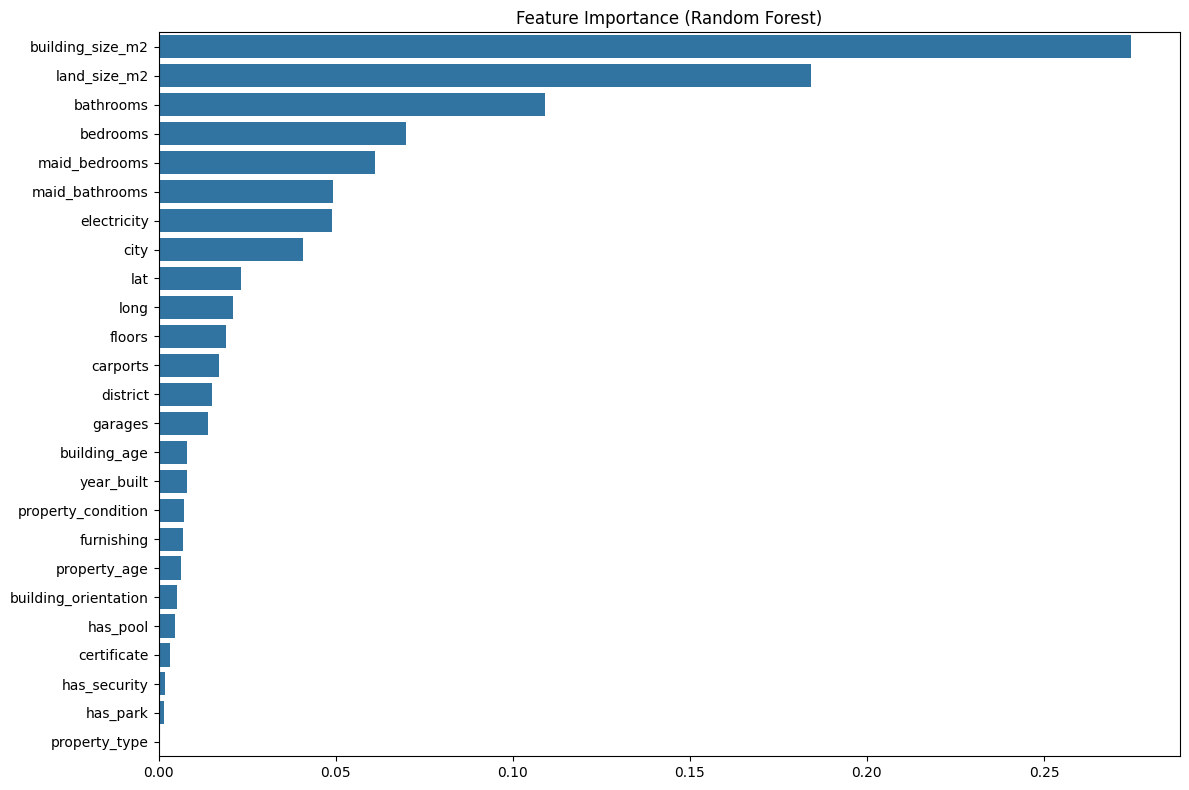

In [24]:
plt.figure(figsize=(12, 8))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

In [25]:
# 10. Save Model
import joblib
joblib.dump(best_model, 'house_price_rf_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print("\nModel saved successfully!")


Model saved successfully!


**Kesimpulan 2**

Pada eksperimen kedua, model menunjukkan peningkatan performa yang signifikan dengan nilai R² sebesar 0.9196, yang berarti model mampu menjelaskan sekitar 92% variasi harga rumah. Selain itu, nilai error juga turun drastis: MAE menjadi hanya 0.18 dan RMSE sebesar 0.32, menunjukkan bahwa prediksi model jauh lebih akurat dibanding eksperimen sebelumnya.

Perbedaan utama yang membuat performa meningkat dibanding eksperimen pertama adalah:

1. Pra-pemrosesan data yang lebih lengkap, seperti mengisi missing value, mengolah fitur facilities, serta membuat fitur baru (property_age, has_pool, dll).
2. Transformasi dan normalisasi data numerik menggunakan StandardScaler, sehingga skala fitur menjadi seimbang.

3. Encoding variabel kategorik agar bisa dipahami model.

4. Tuning hyperparameter menggunakan GridSearchCV, yang membantu menemukan kombinasi parameter terbaik untuk Random Forest.

Secara keseluruhan, eksperimen kedua berhasil meningkatkan akurasi model karena pendekatan preprocessing yang lebih matang dan penggunaan pipeline serta tuning parameter yang sistematis.









